# Dependances

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from numba import njit

def time_to_min(time_str):
    hours, minutes = map(int, time_str.split(':'))
    total_seconds = hours * 60 + minutes
    return total_seconds

def min_to_time(minutes):
    minutes=minutes%1440
    hours = minutes // 60
    minutes = minutes % 60
    time_str = '{:02d}:{:02d}'.format(hours, minutes)
    return time_str

def simulate_instance(n = 20,
                      vehicles_availability_time = "6:00",
                      chargers_availability_time = "6:00",
                      min_required_energy = 30,
                      step = 10,
                      max_required_energy = 100,
                      m = 6,
                      charging_powers = [10,20,30,40],
                      delta = None,
                      tho = 60):
    
    vehicles_availability_time = time_to_min(vehicles_availability_time)
    chargers_availability_time = time_to_min(chargers_availability_time)
    
    scheduling_limit = time_to_min("23:59")
    
    requests = np.empty((n,2), dtype = object)
    for i in range(n):
        arrival = np.random.choice(range(vehicles_availability_time,scheduling_limit+1,tho))
        required_energy = np.random.choice(range(min_required_energy,max_required_energy+1,step))
        requests[i] = [min_to_time(arrival),required_energy]

    chargers = np.empty((m,2), dtype = object)
    for i in range(m):
        charger_availability = min_to_time(np.random.choice(range(chargers_availability_time,scheduling_limit+1,tho)))
        charger_power = np.random.choice(charging_powers)
        chargers[i] = [charger_availability, charger_power]

    if delta is None:
        delta = np.ones((n,m), dtype = np.int8)

    scheduling_start_time = min_to_time(min(vehicles_availability_time,chargers_availability_time))
    
    
    Instance={
        "requests":requests,
        "chargers":chargers,
        "delta":delta,
        "tho":tho
    }
    return Instance
    
def calculate_carecs(Instance):
    requests = Instance["requests"]
    chargers = Instance["chargers"]
    delta = Instance["delta"]
    tho = Instance["tho"]

    n,m = len(requests),len(chargers)
    # Calculate p
    p = np.zeros((n,m),dtype=np.int16)
    for i in range(n):
        for j in range(m):
            p[i,j]=ceil(requests[i,1]/((tho/60)*chargers[j,1]))

    # Calculate requests_temp, chargers_temp
    M = np.min([time_to_min(x[0]) for x in requests]+[time_to_min(x[0]) for x in chargers])
    requests_temp = np.array([[int((time_to_min(request[0]) - M)/tho)+1,request[1]] for request in requests])
    chargers_temp = np.array([[int((time_to_min(charger[0]) - M)/tho)+1,charger[1]] for charger in chargers])

    scheduling_start_time = M
    
    return n, m, requests, chargers, delta, tho, scheduling_start_time, requests_temp, chargers_temp, p


@njit
def random_choice(x, size=1, replace=True, p=None):
    n = len(x)
    selected = np.zeros(size, dtype=np.int64)
    possible_indices = np.arange(n)
    
    if p is None:
        p = np.ones(n, dtype=np.float64) / n
        
    for i in range(size):
        cdf = np.cumsum(p)
        r = np.random.rand()
        for index, threshold in enumerate(cdf):
            if r <= threshold:
                selected[i] = x[possible_indices[index]]
                break
                
        if replace == False and size > 1:
            possible_indices = np.delete(possible_indices, index)
            p = np.array([a for k,a in enumerate(p) if k != index])
            p = p / p.sum()
            
    return selected

@njit
def find_availability(schedule,chargers_temp,j):
    sub_schedule = schedule[schedule[:,0]==j+1]
    sub_schedule = sub_schedule[np.argsort(sub_schedule[:,1])]
    N = len(sub_schedule)
    availability = np.zeros((N+1,2), dtype = np.int64)
    if N>0:
        availability[0] = np.array([chargers_temp[j,0],sub_schedule[0,1]-1])
        for k in range(1,N):
            availability[k] = np.array([sub_schedule[k-1,2]+1,sub_schedule[k,1]-1])
        availability[N] = np.array([sub_schedule[N-1,2]+1,123456789])
    else:
        availability[0] = np.array([chargers_temp[j,0],123456789])
    return availability

@njit
def find_candidate_charging_periods(i, j, availability, requests_temp, chargers_temp, p):
    candidate_charging_periods =[]
    for k in range(len(availability)):
        if availability[k,1] == 123456789:
            candidate_charging_periods.append(k)
        elif availability[k,1]-max(availability[k,0],requests_temp[i,0])+1>=p[i,j]:
            candidate_charging_periods.append(k)
    return np.array(candidate_charging_periods)

@njit
def generate_random_schedule(delta, requests_temp, chargers_temp, p, sigma = 5):
    n = len(requests_temp)
    m = len(chargers_temp)
    schedule = np.zeros((n,3), dtype = np.int32)
    vehicles_indexes = np.arange(n)
    np.random.shuffle(vehicles_indexes)
    for i in vehicles_indexes:
        candidate_chargers = np.arange(m)[delta[i,:] == 1]
        j = np.random.choice(candidate_chargers)
        schedule = place_vehicle_on_charger(i, j, schedule, requests_temp, chargers_temp, p, sigma)
    return schedule

@njit
def place_vehicle_on_charger(i, j, schedule, requests_temp, chargers_temp, p, sigma):
    n,m = p.shape
    schedule = schedule.copy()

    availability = find_availability(schedule,chargers_temp,j)
    candidate_charging_periods = find_candidate_charging_periods(i, j, availability, requests_temp, chargers_temp, p)
    
    N = len(candidate_charging_periods)
    probabilities = np.zeros(N, dtype = np.float64)
    probabilities = (N-np.arange(N))/(N*(N+1)/2)
    k = random_choice(candidate_charging_periods, p = probabilities)[0]
    
    A = max(availability[k,0],requests_temp[i,0])
    if availability[k,1] == 123456789:
        ts = A+int(np.abs(sigma*np.random.randn()))
    else:
        ts = np.random.choice(np.arange(A,availability[k,1]-p[i,j]+2))
        
    schedule[i] = [j+1,ts,ts+p[i,j]-1]
    
    return schedule


@njit
def exchange_schedules(schedule1,schedule2):
    schedule2 = schedule2.copy()
    n = len(schedule1)
    can_be_placed = []
    for i in range(n):
        placable = True
        for j in range(n):
            if schedule1[i, 0] == schedule2[j, 0]:
                if schedule1[i, 1] > schedule2[j, 2] or schedule2[j, 1] > schedule1[i, 2]:
                    pass
                else:
                    placable = False
                    break
        if placable:
            can_be_placed.append(i)
    K = ceil(len(can_be_placed)/3)
    to_be_replaced = random_choice(can_be_placed, size = K, replace = False)
    for i in to_be_replaced:
        schedule2[i] = schedule1[i]
    return schedule2


@njit
def change_vehicle_charger(schedule,requests_temp,chargers_temp,delta,p,sigma):
    n,m = p.shape
    schedule = schedule.copy()
    
    candidate_vehicles = np.array([i for i in range(n) if np.sum(delta[i,:])>1], dtype = np.int32)
    i = np.random.choice(candidate_vehicles)
    
    candidate_chargers = np.array([j for j in range(m) if delta[i,j] == 1 and j!=schedule[i,0]-1], dtype = np.int32)
    j = np.random.choice(candidate_chargers)
    
    return place_vehicle_on_charger(i, j, schedule, requests_temp, chargers_temp, p, sigma)



@njit
def f(schedule, chargers_temp):
    n = len(schedule)
    T1 = np.min(schedule[:,1])
    T2 = np.max(schedule[:,2])
    Wg = np.zeros(T2-T1+1, dtype = np.float64)
    for i in range(n):
        for t in range(schedule[i,1],schedule[i,2]+1): 
            Wg[t-T1] += chargers_temp[schedule[i,0]-1,1]
    return np.array([np.max(Wg) ,np.sum(schedule[:,2])], dtype = np.float32)


@njit
def fast_non_dominated_sort(obj1, obj2):
    N = len(obj1)
    S = np.zeros((N, N), dtype = np.int64)
    ranks = np.zeros(N, dtype = np.int64)
    fronts = []
    count = N
    front = []
    for p in range(N):
        for q in range(N):
            if (obj1[p] < obj1[q] and obj2[p] <= obj2[q]) or (obj1[p] <= obj1[q] and obj2[p] < obj2[q]):
                S[p][q] = 1
    for p in range(N):
        if np.sum(S[:, p]) == 0:
            front.append(p)
            ranks[p] = 0
            count -= 1
    fronts.append(np.array(front))
    n = np.sum(S, axis=0)
    i = 0
    while count > 0:
        front = []
        for p in fronts[i]:
            for q in range(N):
                if S[p][q] == 1:
                    n[q] -= 1
                    if n[q] == 0:
                        front.append(q)
                        ranks[q] = i + 1
                        count -= 1
        fronts.append(np.array(front))
        i += 1
    return fronts, ranks



@njit
def calculate_crowding_distance(fronts, obj1, obj2):
    objectives = [obj1, obj2]
    d = np.zeros(len(obj1), dtype = np.float64)
    for front in fronts:
        lf = len(front)
        distances = np.zeros(lf, dtype = np.float64)
        distances[0] = 999999999999
        distances[-1] = 999999999999
        for obj in objectives:
            sorted_front = np.empty(lf, dtype=np.int32)
            indices = np.argsort(np.array([obj[i] for i in front]))
            for idx in range(lf):
                sorted_front[idx] = front[indices[idx]]
            for j in range(1, lf - 1):
                diff = obj[sorted_front[-1]] - obj[sorted_front[0]]
                if diff == 0:
                    distances[j] = 999999999999
                else:
                    distances[j] += (obj[sorted_front[j + 1]] - obj[sorted_front[j - 1]]) / diff
        for idx in range(lf):
            d[sorted_front[idx]] = distances[idx]
    return d


@njit
def sort_population(population, chargers_temp, population_size):
    N = len(population)
    obj1 = np.zeros(N, dtype = np.float64)
    obj2 = np.zeros(N, dtype = np.float64)
    sorted_fronts = np.zeros(N, dtype = np.int64)
    
    for i in range(N):
        obj1[i],obj2[i] = f(population[i], chargers_temp)
    fronts, ranks = fast_non_dominated_sort(obj1, obj2)
    distances = calculate_crowding_distance(fronts, obj1, obj2)
    
    i = 0
    for front in fronts:
        temp_front = front[np.argsort(-distances[front])]
        for k in temp_front:
            sorted_fronts[i] = k
            i+=1

    I = sorted_fronts[:population_size]
    return population[I], obj1[I], obj2[I], ranks[I], distances[I]


@njit
def Initialize_population(population_size, delta, requests_temp, chargers_temp, p):
    n = len(requests_temp)
    population = np.zeros((population_size,n,3), dtype = np.int64)
    for k in range(population_size):
        population[k] = generate_random_schedule(delta, requests_temp, chargers_temp, p, sigma = k+1)
    return population

@njit
def FN(schedule, requests_temp, chargers_temp, delta, p, sigma, pc):
    n,m = p.shape
    schedule = schedule.copy()
    candidate_vehicles = np.array([i for i in range(n) if np.sum(delta[i,:])>1], dtype = np.int32)
    for _ in range(ceil(pc*n)):
        i = np.random.choice(candidate_vehicles)
        candidate_chargers = np.array([j for j in range(m) if delta[i,j]==1])
        j = np.random.choice(candidate_chargers)
        schedule = place_vehicle_on_charger(i, j, schedule, requests_temp, chargers_temp, p, sigma).copy()
    return schedule


@njit
def selection(population, ranks, distances):
    population_size = len(population)
    N = int(population_size/4)
    probabilities = (N-np.arange(N))/(N*(N+1)/2)
    i1,i2 = random_choice(np.arange(N), size = 2, replace = False, p = probabilities)
    if ranks[i1]<ranks[i2]:
        return population[i1]
    elif ranks[i2]<ranks[i1]:
        return population[i2]
    else:
        if distances[i1] > distances[i2]:
            return population[i1]
        elif distances[i2] > distances[i1]:
            return population[i2]
        else:
            return population[i1]
            
@njit
def crossover(schedule1,schedule2):
    return exchange_schedules(schedule2,schedule1), exchange_schedules(schedule1,schedule2)

    
@njit    
def mutation(schedule,requests_temp,chargers_temp,delta,p,sigma,pm2):
    n = len(requests_temp)
    for i in range(ceil(pm2*n)):
        schedule = change_vehicle_charger(schedule,requests_temp,chargers_temp,delta,p,sigma)
    return schedule



@njit
def NSGA2_main(requests_temp, chargers_temp, p, delta, population_size, generations, pm1, pm2, sigma):
    n, m = p.shape
    offspring = np.empty((population_size, n, 3), dtype = np.int64)
    combined_population = np.empty((2*population_size, n, 3), dtype = np.int64)

    
    population = Initialize_population(population_size, delta, requests_temp, chargers_temp, p)
    population, obj1, obj2, ranks, distances = sort_population(population, chargers_temp, population_size)
    
    for gen in range(generations):
        
        k = 0
        while k < population_size:
            parent1 = selection(population, ranks, distances)
            parent2 = selection(population, ranks, distances)
            child1, child2 = crossover(parent1, parent2)
            if np.random.rand() < pm1:
                child1 = mutation(child1,requests_temp,chargers_temp,delta,p,sigma,pm2)
            if np.random.rand() < pm1:
                child2 = mutation(child2,requests_temp,chargers_temp,delta,p,sigma,pm2)
            offspring[k] = child1
            k += 1
            if k < population_size:
                offspring[k] = child2
                k += 1
                
        for k in range(2*population_size):
            if k<population_size:
                combined_population[k] = population[k]
            else:
                combined_population[k] = offspring[k-population_size]
        population, obj1, obj2, ranks, distances = sort_population(combined_population, chargers_temp, population_size)

    pf_indexes = np.array([i for i in range(population_size) if ranks[i] == 0], dtype = np.int32)
    pareto_front = population[pf_indexes]
    
    pov = np.zeros((len(pf_indexes),2), dtype = np.float64)
    for i,k in enumerate(pf_indexes):
        pov[i] = [obj1[k],obj2[k]]
    return pareto_front, pov

def NSGA2(Instance, population_size=100, generations=200, pm1 = 0.2, pm2 = 0.05, sigma = 10):
    n, m, requests, chargers, delta, tho, scheduling_start_time, requests_temp, chargers_temp, p = calculate_carecs(Instance)
    pareto_front, objectives_values_pareto_front = NSGA2_main(requests_temp, 
                                                            chargers_temp, 
                                                            p, 
                                                            delta, 
                                                            population_size, 
                                                            generations, 
                                                            pm1,
                                                            pm2, 
                                                            sigma)
    result = {
        "pareto_front":pareto_front,
        "objectives_values_pareto_front":objectives_values_pareto_front,
    }
    return result




@njit
def MOCS_main(requests_temp, chargers_temp, p, delta, population_size, generations, perc_abandoned, sigma, pc):
    n = len(requests_temp)
    new_population = np.zeros((population_size,n,3), dtype = np.int64)
    combined_population = np.empty((2*population_size, n, 3), dtype = np.int64)
    num_abandoned = int(perc_abandoned*population_size)

    N = int(population_size/3)
    probabilities = np.zeros(N, dtype = np.float64)
    probabilities = (N-np.arange(N))/(N*(N+1)/2)

    population = Initialize_population(population_size, delta, requests_temp, chargers_temp, p)
    population, obj1, obj2, ranks, distances = sort_population(population, chargers_temp, population_size)

    for gen in range(generations):
        
        for i in range(population_size):
            k = random_choice(np.arange(N),p = probabilities)[0]
            new_population[i] = FN(population[k], requests_temp, chargers_temp, delta, p, sigma, pc)

        for j in range(1,num_abandoned+1):
            population[-j] = FN(population[-j], requests_temp, chargers_temp, delta, p, sigma, pc)

        for k in range(2*population_size):
            if k<population_size:
                combined_population[k] = population[k]
            else:
                combined_population[k] = new_population[k-population_size]
        population, obj1, obj2, ranks, distances = sort_population(combined_population, chargers_temp, population_size)


    pf_indexes = np.array([i for i in range(population_size) if ranks[i] == 0], dtype = np.int32)
    pareto_front = population[pf_indexes]
    
    pov = np.zeros((len(pf_indexes),2), dtype = np.float64)
    for i,k in enumerate(pf_indexes):
        pov[i] = [obj1[k],obj2[k]]
    
    return pareto_front, pov

def MOCS(Instance, population_size = 100, generations = 200, perc_abandoned = 0.2, sigma = 5, pc = 0.1):
    n, m, requests, chargers, delta, tho, scheduling_start_time, requests_temp, chargers_temp, p = calculate_carecs(Instance)
    pareto_front, objectives_values_pareto_front = MOCS_main(requests_temp, 
                                                             chargers_temp, 
                                                             p, 
                                                             delta,  
                                                             population_size, 
                                                             generations, 
                                                             perc_abandoned, 
                                                             sigma,
                                                             pc)
    result = {
        "pareto_front":pareto_front,
        "objectives_values_pareto_front":objectives_values_pareto_front
    }
    return result

# NSGA-II

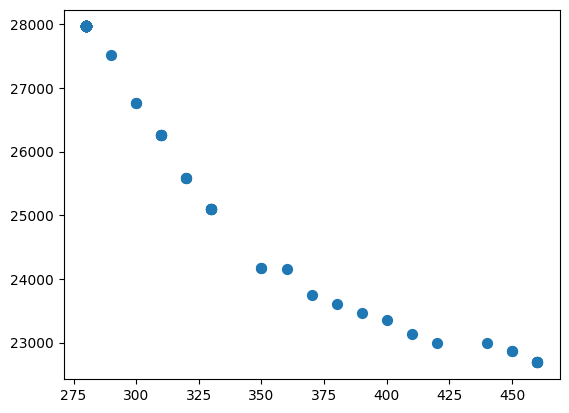

In [2]:
Instance = simulate_instance(n = 100,
vehicles_availability_time = "00:00",
chargers_availability_time = "00:00",
min_required_energy = 30,
step = 10,
max_required_energy = 300,
m = 25,
charging_powers = [10,20,30,40,50],
delta = None,
tho = 10)

result = NSGA2(Instance, population_size = 100, generations = 100, pm1 = 0.2, pm2 = 0.05, sigma = 1)
pov = result['objectives_values_pareto_front']
plt.figure()
plt.scatter(pov[:,0], pov[:,1], s=50)
plt.show()

# MOCS

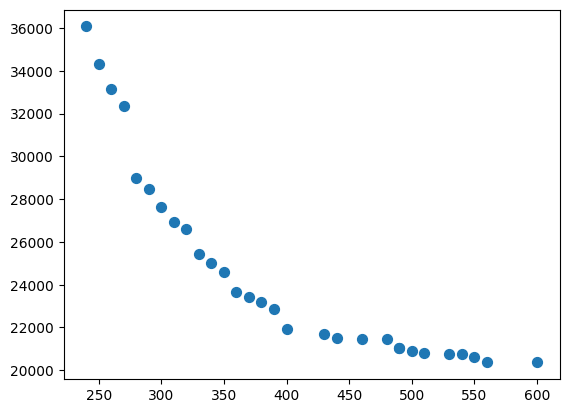

In [3]:
Instance = simulate_instance(n = 100,
vehicles_availability_time = "00:00",
chargers_availability_time = "00:00",
min_required_energy = 30,
step = 10,
max_required_energy = 300,
m = 25,
charging_powers = [10,20,30,40,50],
delta = None,
tho = 10)

result = MOCS(Instance, population_size = 100, generations = 100, perc_abandoned = 0.25, sigma = 1, pc = 0.05)
pov = result['objectives_values_pareto_front']
plt.figure()
plt.scatter(pov[:,0], pov[:,1], s=50)
plt.show()

# Single execution comparaison

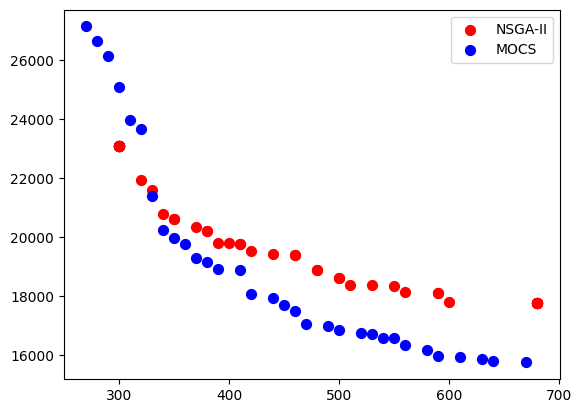

In [6]:
Instance = simulate_instance(n = 100,
vehicles_availability_time = "00:00",
chargers_availability_time = "00:00",
min_required_energy = 30,
step = 10,
max_required_energy = 300,
m = 25,
charging_powers = [10,20,30,40,50],
delta = None,
tho = 10)

result = NSGA2(Instance, population_size = 100, generations = 100, pm1 = 0.2, pm2 = 0.05, sigma = 1)
pov = result['objectives_values_pareto_front']
plt.figure()
plt.scatter(pov[:,0], pov[:,1], s=50, c = "red", label = "NSGA-II")


result = MOCS(Instance, population_size = 100, generations = 100, perc_abandoned = 0.25, sigma = 1, pc = 0.05)
pov = result['objectives_values_pareto_front']
plt.scatter(pov[:,0], pov[:,1], s=50, c = "blue", label = "MOCS")
plt.legend()
plt.show()

## Draw a random schedule

## Illustration

## Functional domain visualization

## Works well ?

## Operators vizualization

### Visualize FN

In [ ]:
Instance = load_results("Evaluation\\Instances.pkl")[16]

n, m, requests, chargers, delta, tho, scheduling_start_time, requests_temp, chargers_temp, p = calculate_carecs(Instance)

sigma = 10

original_schedule = generate_random_schedule(delta, requests_temp, chargers_temp, p, sigma = 5)
original_objective = f(original_schedule, chargers_temp)
figure = plt.figure()
plt.plot(original_objective[0],original_objective[1], c = "red", marker = ".", ms = 20)
for _ in range(10):
    schedule = FN(original_schedule, requests_temp, chargers_temp, delta, p, sigma)
    objective = f(schedule, chargers_temp)
    plt.plot(objective[0],objective[1], c = "black", marker = ".", ms = 10)
plt.title("FN")
plt.show()

### Visualize Mutation

### Visualize Crossover

## Execution Time

In [ ]:
Instance = simulate_instance(
n = 200,
vehicles_availability_time = "19:00",
chargers_availability_time = "19:00",
min_required_energy = 30,
step = 10,
max_required_energy = 100,
m = 10,
charging_powers = [10,20,30,40],
delta = None,
tho = 10
)



N = 2
u = np.zeros(N)
for k in range(N):
    t = timer()
    NSGA2(Instance, population_size = 200, generations = 100, mutation_rate = 0.2, sigma = 10)
    u[k] = timer()-t
plt.plot(u)
plt.show()

In [ ]:
Instances = []
n_vals = [50]
for n in n_vals:
    m = ceil(n/4)
    for k in range(1):
        Instance = simulate_instance(
        n = n,
        vehicles_availability_time = "00:00",
        chargers_availability_time = "00:00",
        min_required_energy = 20,
        step = 10,
        max_required_energy = 300,
        m = m,
        charging_powers = [10,20,30,40,50],
        delta = None,
        tho = 10
        )
        Instances.append(Instance)